# VAE-CNN-Fashion-Keras

In [ ]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

### VAE encoder network

In [1]:
img_shape = (28, 28, 1)
batch_size = 16

# Dimensionality of the latent space: a 2D plane
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

### Latent-space-sampling function

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### VAE decoder network, mapping latent space points to images

In [3]:
# VAE decoder network, mapping latent space points to images
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshapes z into a feature map of the same shape as the feature map 
# just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# Uses a Conv2DTranspose layer and Conv2D layer to decode z into a feature map 
# the same size as the original image input
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',

                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# Instantiates the decoder model, which turns “decoder_input” into the decoded image
decoder = Model(decoder_input, x)

# Applies it to z to recover the decoded z
z_decoded = decoder(z)

### vae loss function : reconstruction loss + KL loss

In [4]:
def vae_loss(x, z_decoded):
    recon_loss = K.mean(keras.metrics.mean_squared_error(x, z_decoded))
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(recon_loss + kl_loss)

### import dataset and view the created model

(?, ?, ?, ?) (?, ?, ?, 1)


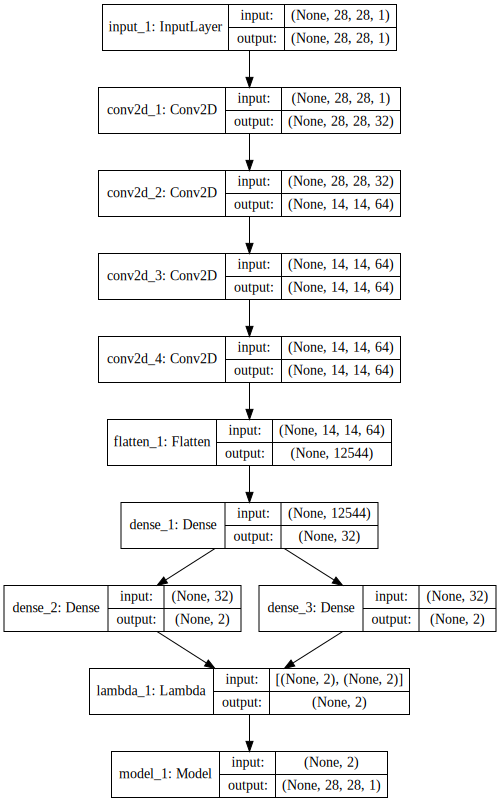

In [5]:
from keras.datasets import fashion_mnist

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss= vae_loss)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
(x_train, _ ), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 399us/step - loss: 0.0413 - val_loss: 0.0328
Epoch 2/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.0321 - val_loss: 0.0322
Epoch 3/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.0311 - val_loss: 0.0308
Epoch 4/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.0304 - val_loss: 0.0302
Epoch 5/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 6/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.0295 - val_loss: 0.0295
Epoch 7/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.0293 - val_loss: 0.0295
Epoch 8/10
60000/60000 [==============================] - 23s 392us/step - loss: 0.0290 - val_loss: 0.0293
Epoch 9/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.0289 - val_

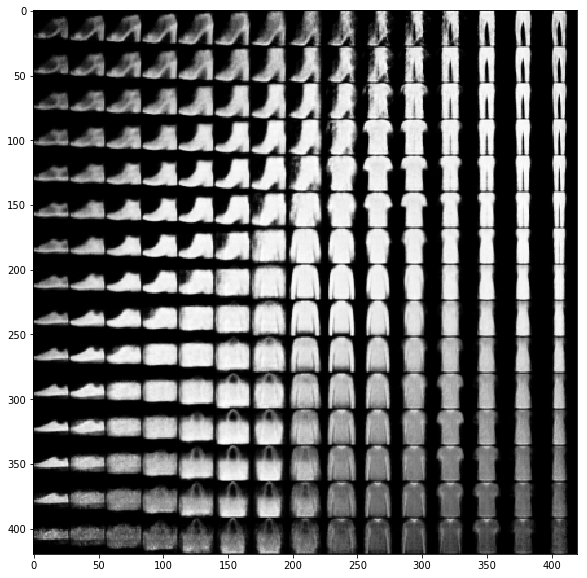

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Transforms linearly spaced coordinates to produce values of the latent variable z 
# because the prior of the latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Repeats z multiple times to form a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        # Decodes the batch into digit images
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        # Reshapes the first digit in the batch from 28 × 28 × 1 to 28 × 28
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()